In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
from kmeans_radec import KMeans, kmeans_sample
import matplotlib
from scipy.interpolate import interp1d
import os

### IceCube data handler class
We start with one for the 3-year data, then we update the methods needed to deal with the 10-year data.

In [2]:
class ICData3Y(object):
    def __init__(self, logE_ranges=[2.0, 3.0, 4.0, 5.0, 6.0], coords='G'):
        self.seasons = ['79-2010', '86-2011', '86-2012']
        self.predir = 'IceCube_dataset3'
        self.lE_ranges = logE_ranges
        self.nbins_E = len(logE_ranges)-1
        self.nseasons = len(self.seasons)
        self.coords = coords
        self.r_c2g = hp.Rotator(coord=['C', 'G'])
        self.r_g2c = hp.Rotator(coord=['G', 'C'])

    def _get_events_filename(self, season_name):
        return f'{self.predir}/IC{season_name}-events.txt'

    def _get_aeff_filename(self, season_name):
        return f'{self.predir}/IC{season_name}-TabulatedAeff.txt'

    def get_events(self, season):
        # Returns one catalog per energy bin for this season
        season_name = self.seasons[season]
        fname = self._get_events_filename(season_name)
        d = np.genfromtxt(fname, names=True)
        cats = []
        for i in range(self.nbins_E):
            lE_0 = self.lE_ranges[i]
            lE_f = self.lE_ranges[i+1]
            msk = (d['log10EGeV'] >= lE_0) & (d['log10EGeV'] < lE_f)
            cats.append(d[msk])
        return cats

    def get_aeff(self, season, alpha=3.7):
        # Returns an interpolating function per energy bin
        # that contains A_Eff(sin(dec))
        season_name = self.seasons[season]
        fname = self._get_aeff_filename(season_name)
        # Read file
        emin, emax, coszmin, coszmax, aeff = np.loadtxt(fname, unpack=True)
        # Get unique values of log(E)
        lEmin = np.log10(emin)
        lEmax = np.log10(emax)
        lEmin_u = np.unique(lEmin)
        lEmax_u = np.unique(lEmax)
        nE = len(lEmin_u)
        assert len(lEmax_u) == nE

        # Get unique values of sin(dec)
        cosz = 0.5*(coszmax+coszmin)
        sindec_u = -np.unique(cosz)
        ndec = len(sindec_u)
        # Check that this is stored as a rectangular matrix
        # and reshape it as such
        assert nE*ndec == len(aeff)
        aeff = aeff.reshape([nE, ndec])
        # Get effective area per energy bin
        aeff_is = []
        for i in range(self.nbins_E):
            lE_0 = self.lE_ranges[i]
            lE_f = self.lE_ranges[i+1]
            # Select energies in bin
            msk = (lEmin_u >= lE_0) & (lEmax_u <= lE_f)
            aeff_h = aeff[msk]
            lEmin_h = lEmin_u[msk]
            lEmax_h = lEmax_u[msk]
            aeff_coadd = np.sum(aeff_h[:, :]*(10**(lEmax_h*(1-alpha))-
                                              10**(lEmin_h*(1-alpha)))[:, None],
                                axis=0)/(10**(lE_f*(1-alpha))-
                                         10**(lE_0*(1-alpha)))
            # Interpolate
            aeff_i = interp1d(sindec_u, aeff_coadd,
                              bounds_error=False,
                              fill_value=0.0)
            aeff_is.append(aeff_i)
        return aeff_is

    def get_mask(self, nside, aeff, aeff_threshold=0.1,
                 dec_threshold=-5., weight_by_area=True):
        # Returns mask and associated area map
        npix = hp.nside2npix(nside)
        lon, lat = hp.pix2ang(nside, np.arange(npix), lonlat=True)
        if self.coords == 'G':
            _, dec = self.r_g2c(lon, lat, lonlat=True)
        else:
            dec = lat
        if weight_by_area:
            aeff_map = aeff(np.sin(np.radians(dec)))
            mask = aeff_map > np.amax(aeff_map)*aeff_threshold
        else:
            aeff_map = np.ones(npix)
            mask = np.ones(npix, dtype=bool)
        mask[dec < dec_threshold] = 0
        aeff_map[dec < dec_threshold] = 0
        
        return mask, aeff_map
        
    def get_map_and_mask(self, nside, seasons='all', aeff_threshold=0.1,
                         weight_by_area=True, dec_threshold=-5.):
        # Returns overdensity map and associated mask
        if seasons == 'all':
            seasons = range(self.nseasons)

        npix = hp.nside2npix(nside)
        nmap_t = np.zeros([self.nbins_E, npix])
        inv_aeff_t = np.zeros([self.nbins_E, npix])
        mask_t = np.ones(npix, dtype=bool)
        for i in seasons:
            cats = self.get_events(i)
            aeff_i = self.get_aeff(i)
            for j, cat in enumerate(cats):
                if self.coords == 'G':
                    lon, lat = self.r_c2g(cat['RAdeg'],
                                          cat['Decdeg'],
                                          lonlat=True)
                else:
                    lon = cat['RAdeg']
                    lat = cat['Decdeg']
                ipix = hp.ang2pix(nside, lon, lat, lonlat=True)
                ncount = np.bincount(ipix, minlength=npix)
                print(f"Season {i}, energy bin {j}: found {np.sum(ncount)} events")
                mask, aeff_map = self.get_mask(nside, aeff_i[j],
                                               aeff_threshold=aeff_threshold,
                                               dec_threshold=dec_threshold,
                                               weight_by_area=weight_by_area)
                mask_t *= mask
                nmap_t[j, mask] += ncount[mask]/aeff_map[mask]
                inv_aeff_t[j, mask] += 1/aeff_map[mask]

        delta = np.zeros([self.nbins_E, npix])
        for j in range(self.nbins_E):
            nmap = np.zeros(npix)
            nmap[mask_t] = nmap_t[j][mask_t]/inv_aeff_t[j][mask_t]
            nmean = np.sum(nmap*mask_t)/np.sum(mask_t)
            delta[j, :] = (nmap/nmean-1)*mask_t
        return delta, mask_t.astype(float)

This illustrates the maps you can get from the 3-year data

Season 0, energy bin 0: found 1301 events
Season 0, energy bin 1: found 56074 events
Season 0, energy bin 2: found 16240 events
Season 0, energy bin 3: found 18931 events
Season 1, energy bin 0: found 37211 events
Season 1, energy bin 1: found 49457 events
Season 1, energy bin 2: found 34690 events
Season 1, energy bin 3: found 14654 events
Season 2, energy bin 0: found 39698 events
Season 2, energy bin 1: found 36088 events
Season 2, energy bin 2: found 15604 events
Season 2, energy bin 3: found 13520 events
Season 0, energy bin 0: found 1301 events
Season 0, energy bin 1: found 56074 events
Season 0, energy bin 2: found 16240 events
Season 0, energy bin 3: found 18931 events
Season 1, energy bin 0: found 37211 events
Season 1, energy bin 1: found 49457 events
Season 1, energy bin 2: found 34690 events
Season 1, energy bin 3: found 14654 events
Season 2, energy bin 0: found 39698 events
Season 2, energy bin 1: found 36088 events
Season 2, energy bin 2: found 15604 events
Season 2, ene

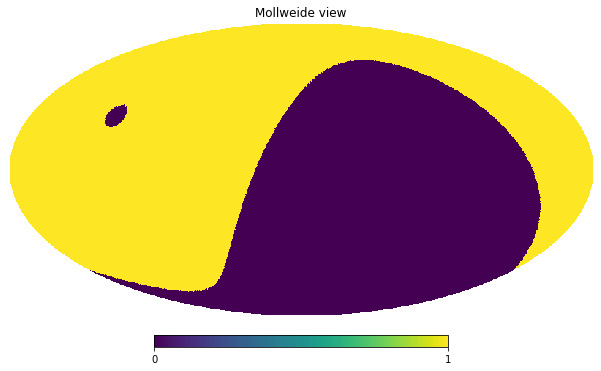

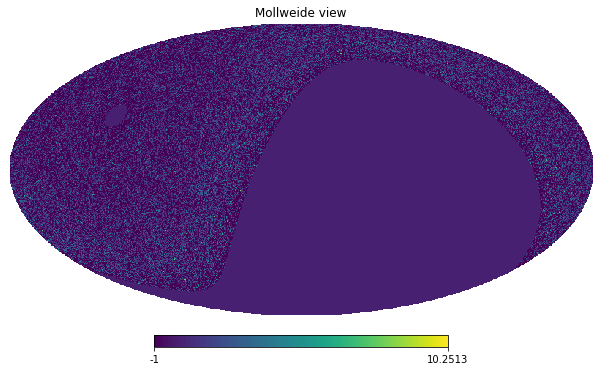

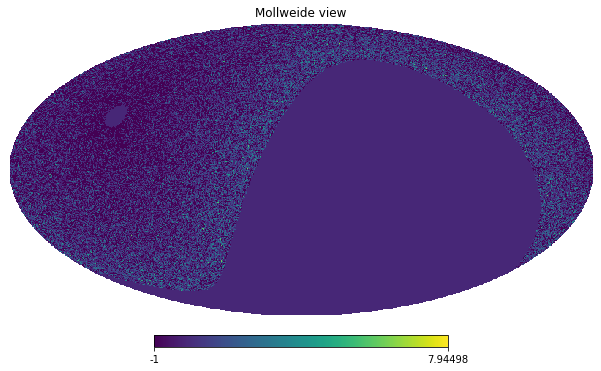

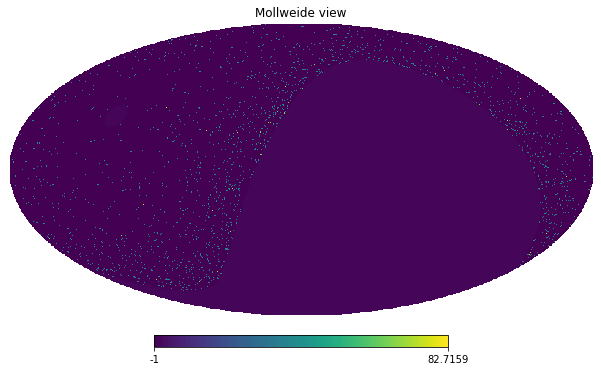

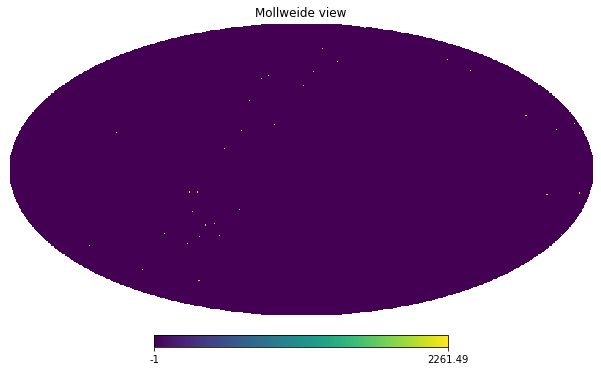

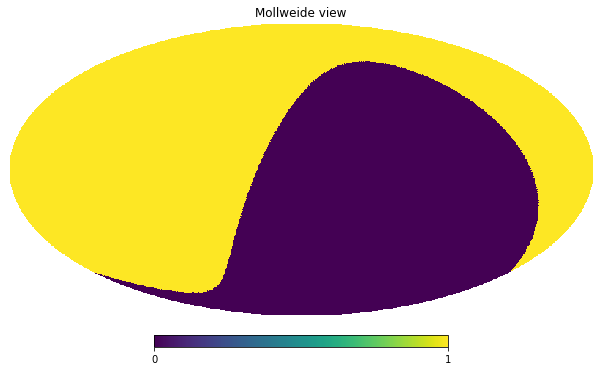

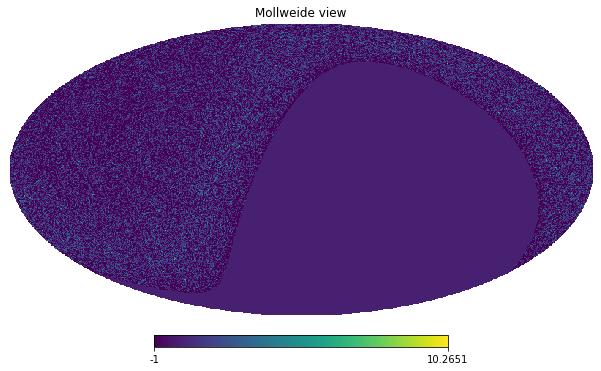

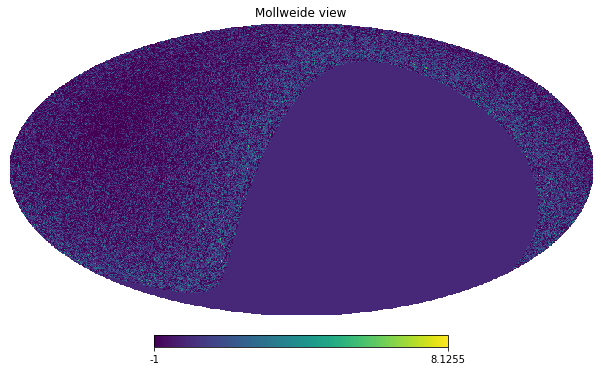

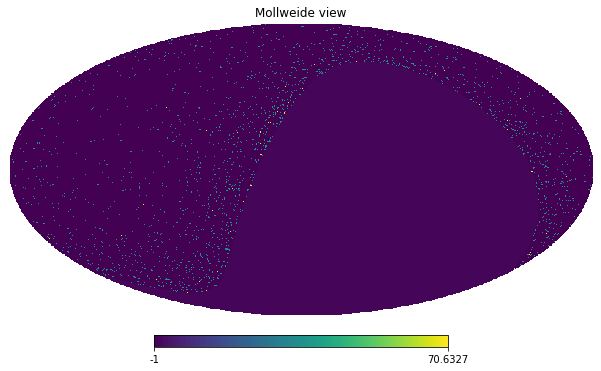

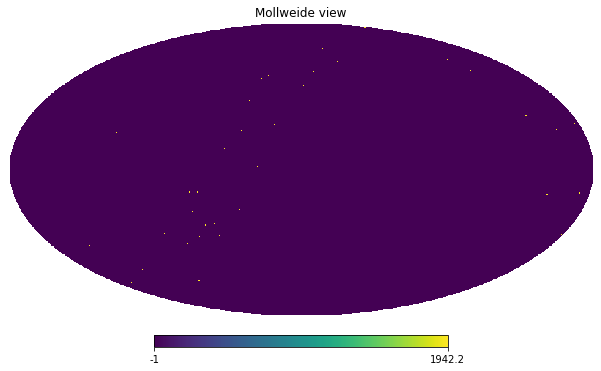

In [3]:
d = ICData3Y()
delta, mask = d.get_map_and_mask(128, weight_by_area=True)
hp.mollview(mask)
for m in delta:
    hp.mollview(m)
delta, mask = d.get_map_and_mask(128, weight_by_area=False)
hp.mollview(mask)
for m in delta:
    hp.mollview(m)

Now the class for the 10-year data. We make it inherit from the 3-year data class so we only need to update the methods that deal with the file formatting.

In [4]:
class ICData10Y(ICData3Y):
    def __init__(self, logE_ranges=[2.0, 3.0, 4.0, 5.0, 6.0], coords='G'):
        self.seasons = ['40', '59', '79', '86_I', '86_II',
                        '86_III', '86_IV', '86_V', '86_VI', '86_VII']
        self.predir = 'IceCube_dataset10'
        self.lE_ranges = logE_ranges
        self.nbins_E = len(logE_ranges)-1
        self.nseasons = len(self.seasons)
        self.coords = coords
        self.r_c2g = hp.Rotator(coord=['C', 'G'])
        self.r_g2c = hp.Rotator(coord=['G', 'C'])

    def _get_events_filename(self, season_name):
        return f'{self.predir}/events/IC{season_name}_exp.csv'

    def _get_aeff_filename(self, season_name):
        if season_name in self.seasons[-5:]:
            season_name = '86_II'
        return f'{self.predir}/irfs/IC{season_name}_effectiveArea.csv'

    def get_events(self, season):
        # Returns one catalog per energy bin for this season
        season_name = self.seasons[season]
        fname = self._get_events_filename(season_name)
        d = np.genfromtxt(fname, names=True)
        cats = []
        for i in range(self.nbins_E):
            lE_0 = self.lE_ranges[i]
            lE_f = self.lE_ranges[i+1]
            msk = (d['log10EGeV'] >= lE_0) & (d['log10EGeV'] < lE_f)
            cats.append(d[msk])
        return cats

    def get_aeff(self, season, alpha=3.7):
        # Returns an interpolating function per energy bin
        # that contains A_Eff(sin(dec))
        season_name = self.seasons[season]
        fname = self._get_aeff_filename(season_name)
        # Read file
        lEmin, lEmax, decmin, decmax, aeff = np.loadtxt(fname, unpack=True)
        # Get unique values of log(E)
        lEmin_u = np.unique(lEmin)
        lEmax_u = np.unique(lEmax)
        nE = len(lEmin_u)
        assert len(lEmax_u) == nE

        # Get unique values of sin(dec)
        dec = 0.5*(decmin+decmax)
        sindec_u = np.sin(np.radians(np.unique(dec)))
        ndec = len(sindec_u)
        # Check that this is stored as a rectangular matrix
        # and reshape it as such
        assert nE*ndec == len(aeff)
        aeff = aeff.reshape([ndec, nE]).T
        # Get effective area per energy bin
        aeff_is = []
        for i in range(self.nbins_E):
            lE_0 = self.lE_ranges[i]
            lE_f = self.lE_ranges[i+1]
            # Select energies in bin
            msk = (lEmin_u >= lE_0) & (lEmax_u <= lE_f)
            aeff_h = aeff[msk]
            lEmin_h = lEmin_u[msk]
            lEmax_h = lEmax_u[msk]
            aeff_coadd = np.sum(aeff_h[:, :]*(10**(lEmax_h*(1-alpha))-
                                              10**(lEmin_h*(1-alpha)))[:, None],
                                axis=0)/(10**(lE_f*(1-alpha))-
                                         10**(lE_0*(1-alpha)))
            # Interpolate
            aeff_i = interp1d(sindec_u, aeff_coadd,
                              bounds_error=False,
                              fill_value=0.0)
            aeff_is.append(aeff_i)
        return aeff_is


And here are the corresponding maps

Season 0, energy bin 0: found 592 events
Season 0, energy bin 1: found 14322 events
Season 0, energy bin 2: found 3601 events
Season 0, energy bin 3: found 17211 events
Season 1, energy bin 0: found 1776 events
Season 1, energy bin 1: found 43098 events
Season 1, energy bin 2: found 11248 events
Season 1, energy bin 3: found 49659 events
Season 2, energy bin 0: found 1202 events
Season 2, energy bin 1: found 56094 events
Season 2, energy bin 2: found 16188 events
Season 2, energy bin 3: found 19046 events
Season 3, energy bin 0: found 36528 events
Season 3, energy bin 1: found 50016 events
Season 3, energy bin 2: found 34643 events
Season 3, energy bin 3: found 14816 events
Season 4, energy bin 0: found 41639 events
Season 4, energy bin 1: found 41767 events
Season 4, energy bin 2: found 15465 events
Season 4, energy bin 3: found 13664 events
Season 5, energy bin 0: found 44526 events
Season 5, energy bin 1: found 45451 events
Season 5, energy bin 2: found 17189 events
Season 5, energy

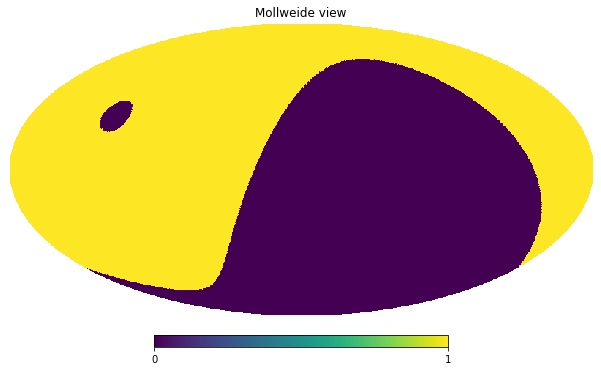

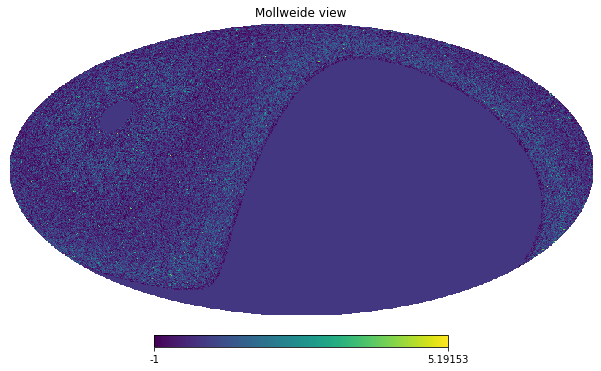

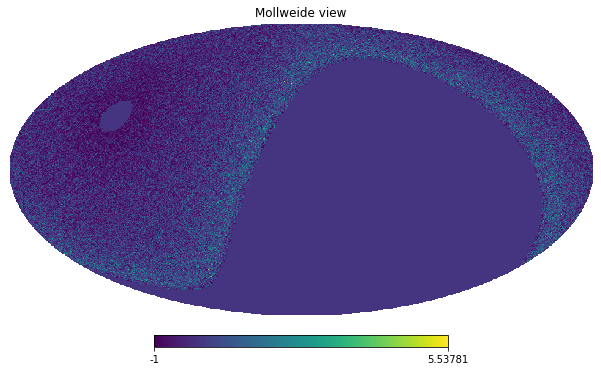

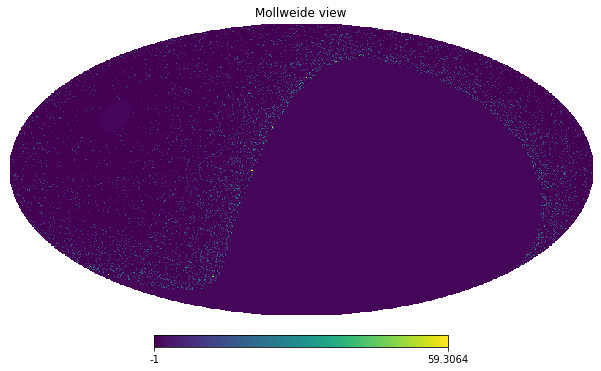

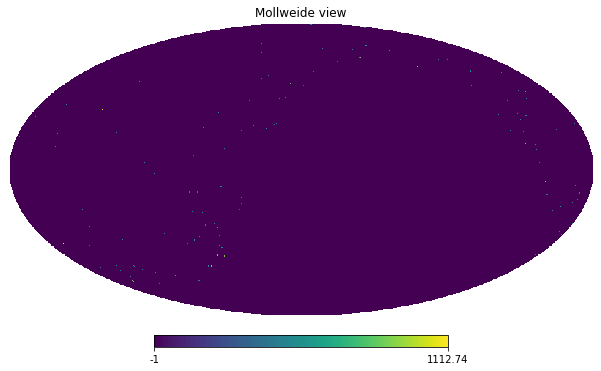

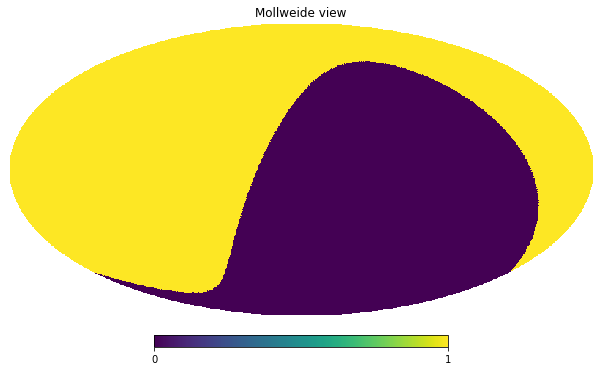

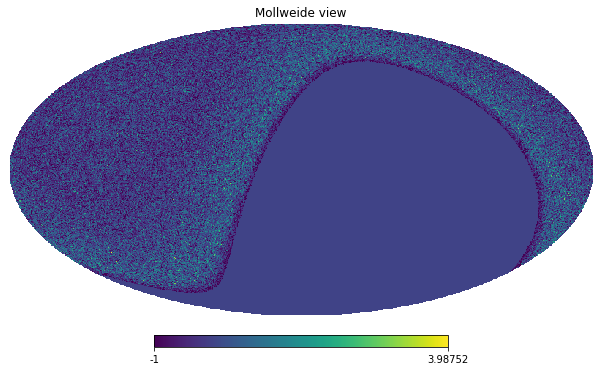

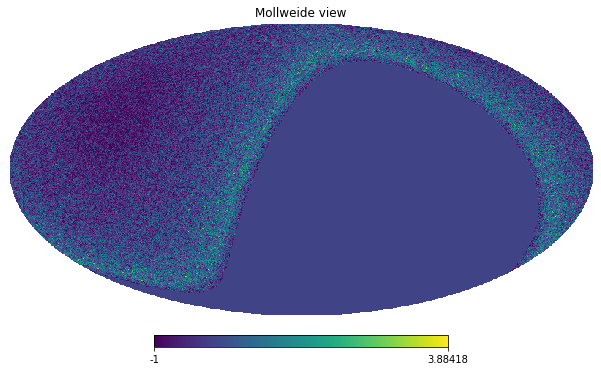

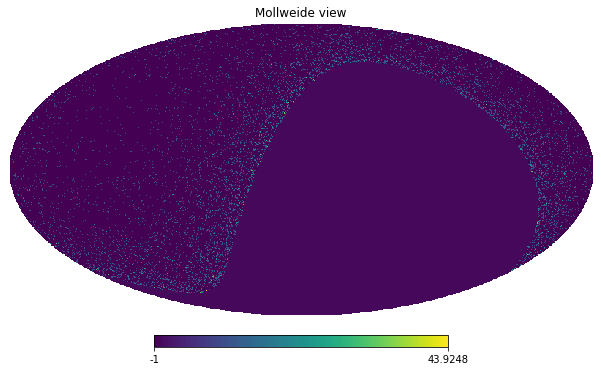

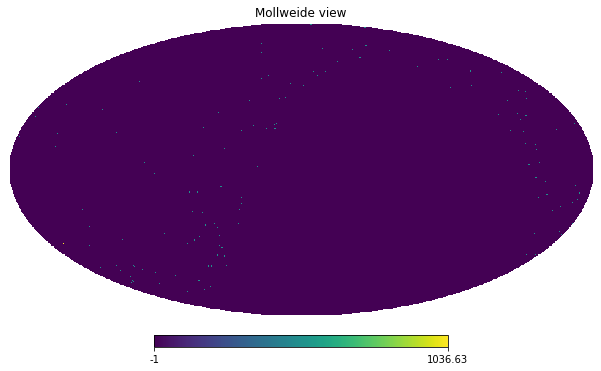

In [5]:
d = ICData10Y()
delta, mask = d.get_map_and_mask(128, weight_by_area=True)
hp.mollview(mask)
for m in delta:
    hp.mollview(m)
delta, mask = d.get_map_and_mask(128, weight_by_area=False)
hp.mollview(mask)
for m in delta:
    hp.mollview(m)

### Compute all power spectra

1. Generate neutrino maps and mask

In [6]:
nside = 128
d = ICData10Y()
delta_nu, mask_nu = d.get_map_and_mask(nside, weight_by_area=True)
n_nu = len(delta_nu)

Season 0, energy bin 0: found 592 events
Season 0, energy bin 1: found 14322 events
Season 0, energy bin 2: found 3601 events
Season 0, energy bin 3: found 17211 events
Season 1, energy bin 0: found 1776 events
Season 1, energy bin 1: found 43098 events
Season 1, energy bin 2: found 11248 events
Season 1, energy bin 3: found 49659 events
Season 2, energy bin 0: found 1202 events
Season 2, energy bin 1: found 56094 events
Season 2, energy bin 2: found 16188 events
Season 2, energy bin 3: found 19046 events
Season 3, energy bin 0: found 36528 events
Season 3, energy bin 1: found 50016 events
Season 3, energy bin 2: found 34643 events
Season 3, energy bin 3: found 14816 events
Season 4, energy bin 0: found 41639 events
Season 4, energy bin 1: found 41767 events
Season 4, energy bin 2: found 15465 events
Season 4, energy bin 3: found 13664 events
Season 5, energy bin 0: found 44526 events
Season 5, energy bin 1: found 45451 events
Season 5, energy bin 2: found 17189 events
Season 5, energy

2. Read galaxy maps and mask

In [7]:
n_g = 6
delta_g = np.array([hp.ud_grade(hp.read_map(f"Galaxy_data/map_WIxSCx2M__{i}.fits"),
                                nside_out=nside)
                    for i in range(n_g)])
mask_g = hp.ud_grade(hp.read_map("Galaxy_data/mask_galaxies.fits"), nside_out=nside)
mask_g[mask_g > 0.5] = 1.
mask_g[mask_g <= 0.5] = 0.
delta_g *= mask_g[None, :]

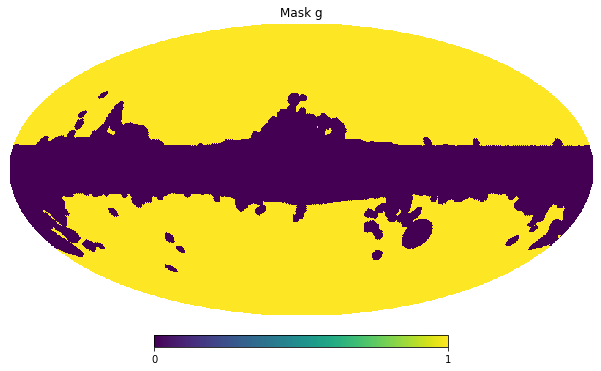

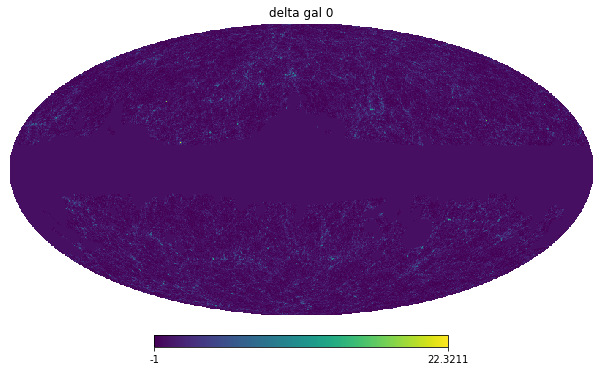

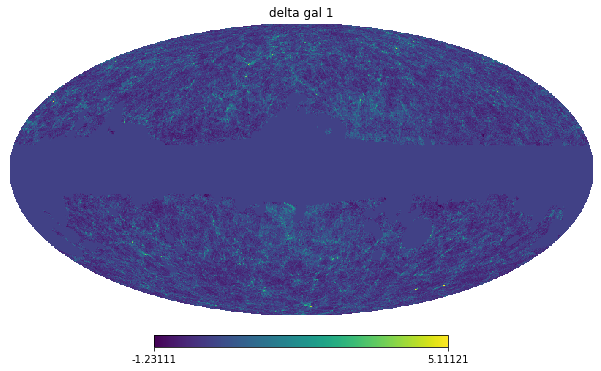

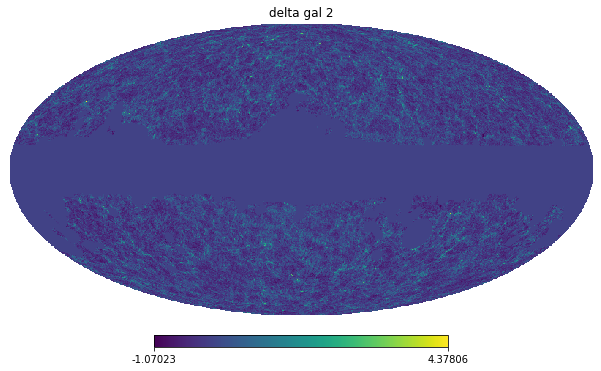

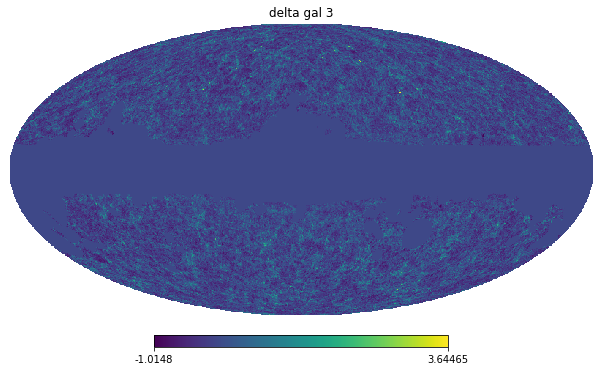

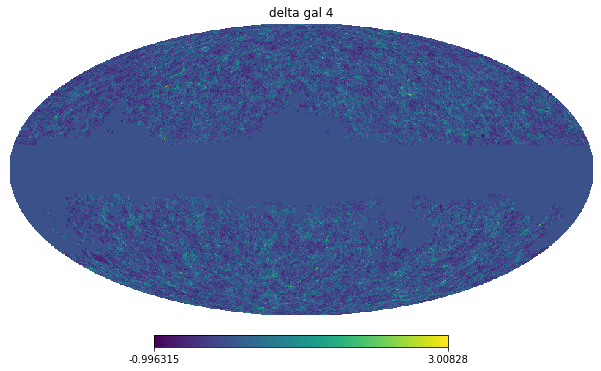

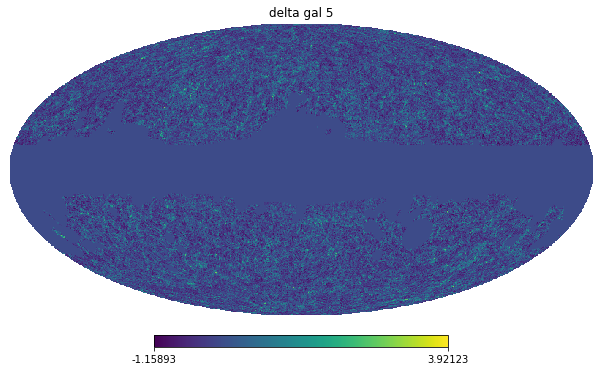

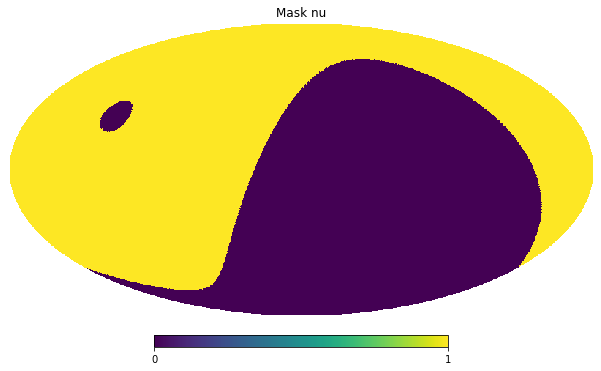

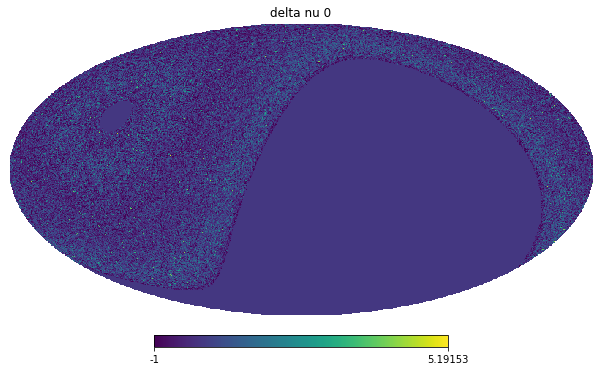

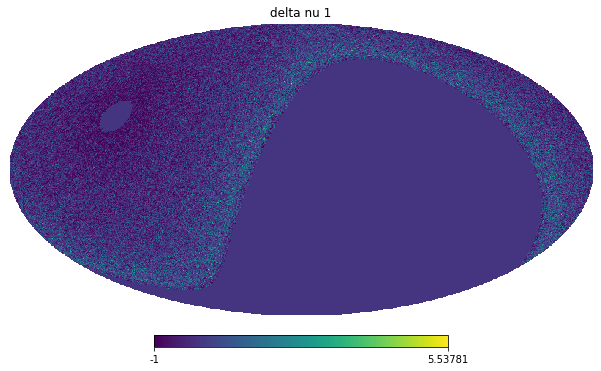

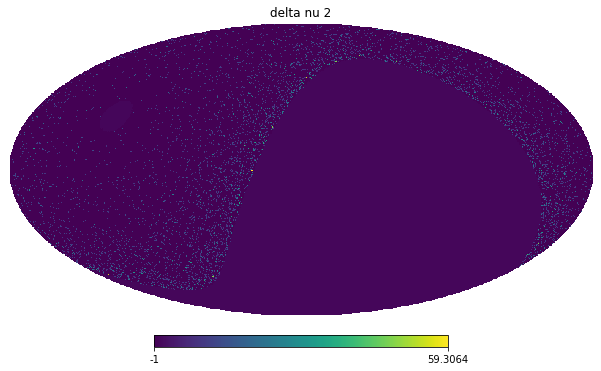

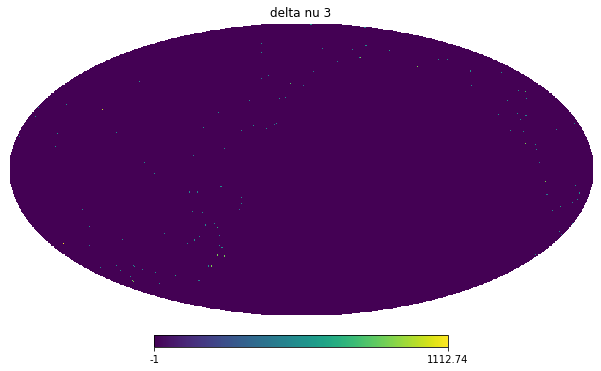

In [8]:
hp.mollview(mask_g, title='Mask g')
for i, m in enumerate(delta_g):
    hp.mollview(m, title=f'delta gal {i}')
hp.mollview(mask_nu, title='Mask nu')
for i, m in enumerate(delta_nu):
    hp.mollview(m, title=f'delta nu {i}')

3. Compute all cross-power spectra

In [9]:
def get_cl(map1, map2, mask_total, delta_ell=50, use_anafast=False, w=None):
    # Returns cross-power spectrum for a pair of maps.
    # You can choose anafast or namaster.
    # You can use namaster workspaces (pass as `w` on input) to accelerate
    # the calculation, assuming that the masks are always the same.
    nside = hp.npix2nside(len(map1))
    if use_anafast:
        fsky = np.mean(mask_total**2)
        cl = hp.anafast(map1*mask_total, map2*mask_total)/fsky
        # Bin
        nbands = (3*nside) // delta_ell
        cl = np.mean(cl.reshape([nbands, -1]), axis=-1)
        ls = np.arange(3*nside)
        ls = np.mean(ls.reshape([nbands, -1]), axis=-1)
    else:
        f1 = nmt.NmtField(mask_total, [map1*mask_total])
        f2 = nmt.NmtField(mask_total, [map2*mask_total])
        b = nmt.NmtBin(nside, nlb=delta_ell)
        if w is None:
            w = nmt.NmtWorkspace()
            w.compute_coupling_matrix(f1, f2, b)
        cl = w.decouple_cell(nmt.compute_coupled_cell(f1, f2))[0]
        ls = b.get_effective_ells()
    return ls, cl

In [10]:
def get_cl_all(mask_total, delta_ell=50, use_anafast=False):
    # This one returns all auto- and cross-spectra for a given mask.
    if use_anafast:
        w = None
    else:
        w = nmt.NmtWorkspace()
        f = nmt.NmtField(mask_total, None, spin=0)
        b = nmt.NmtBin(nside, nlb=delta_ell)
        w.compute_coupling_matrix(f, f, b)
    cls = []
    for i in range(n_nu):
        cls.append([])
        for j in range(n_g):
            ls, cl = get_cl(delta_nu[i], delta_g[j], mask_total, w=w,
                            delta_ell=delta_ell, use_anafast=use_anafast)
            cls[i].append(cl)
    cls = np.array(cls)
    return ls, cls

To compute the errors we need jackknives. Let's generate the jackknive regions and store them in a file for future use.

In [11]:
def get_regions(mask, n_regions, unassigned=hp.UNSEEN):
    """ Generates `n_regions` regions of roughly equal area
    for a given sky mask `mask`, assuming HEALPix "RING"
    ordering. Returns a HEALPix map where each pixel holds
    the index of the region it is assigned to. Unassigned
    pixels will take the `unassigned` value.
    """
    npix = len(mask)
    nside = hp.npix2nside(npix)
    ipix = np.arange(npix)
    ra, dec = hp.pix2ang(nside, ipix, lonlat=True)
    goodpix = mask > 0
    km = kmeans_sample(np.array([ra[goodpix], dec[goodpix]]).T,
                       n_regions, maxiter=100, tol=1.0e-5,
                       verbose=False)
    map_ids = np.full(npix, unassigned)
    map_ids[ipix[goodpix]] = km.labels
    return map_ids

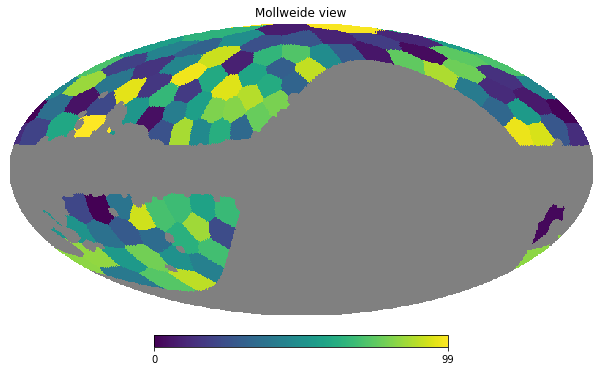

In [12]:
n_jk = 100
fname = f'jk_regions_nside{nside}_njk{n_jk}.npz'
if os.path.isfile(fname):
    jks = np.load(fname)['jks']
else:
    jks = get_regions(mask_g*mask_nu, 100)
    np.savez(fname, jks=jks)
hp.mollview(jks)

Now compute the $C_\ell$ of the data

In [13]:
mask_total = mask_g*mask_nu
ls, cls_all = get_cl_all(mask_total)

Compute the $C_\ell$s for all JK regions

In [14]:
cls_jk = []
for i in range(n_jk):
    print(f'JK {i}')
    mask = mask_total.copy()
    mask[jks == i] = 0.
    _, cl = get_cl_all(mask)
    cls_jk.append(cl)
cls_jk = np.array(cls_jk)

JK 0
JK 1
JK 2
JK 3
JK 4
JK 5
JK 6
JK 7
JK 8
JK 9
JK 10
JK 11
JK 12
JK 13
JK 14
JK 15
JK 16
JK 17
JK 18
JK 19
JK 20
JK 21
JK 22
JK 23
JK 24
JK 25
JK 26
JK 27
JK 28
JK 29
JK 30
JK 31
JK 32
JK 33
JK 34
JK 35
JK 36
JK 37
JK 38
JK 39
JK 40
JK 41
JK 42
JK 43
JK 44
JK 45
JK 46
JK 47
JK 48
JK 49
JK 50
JK 51
JK 52
JK 53
JK 54
JK 55
JK 56
JK 57
JK 58
JK 59
JK 60
JK 61
JK 62
JK 63
JK 64
JK 65
JK 66
JK 67
JK 68
JK 69
JK 70
JK 71
JK 72
JK 73
JK 74
JK 75
JK 76
JK 77
JK 78
JK 79
JK 80
JK 81
JK 82
JK 83
JK 84
JK 85
JK 86
JK 87
JK 88
JK 89
JK 90
JK 91
JK 92
JK 93
JK 94
JK 95
JK 96
JK 97
JK 98
JK 99


In [15]:
cl_errors = np.sqrt(n_jk-1)*np.std(cls_jk, axis=0)

Plot the result!

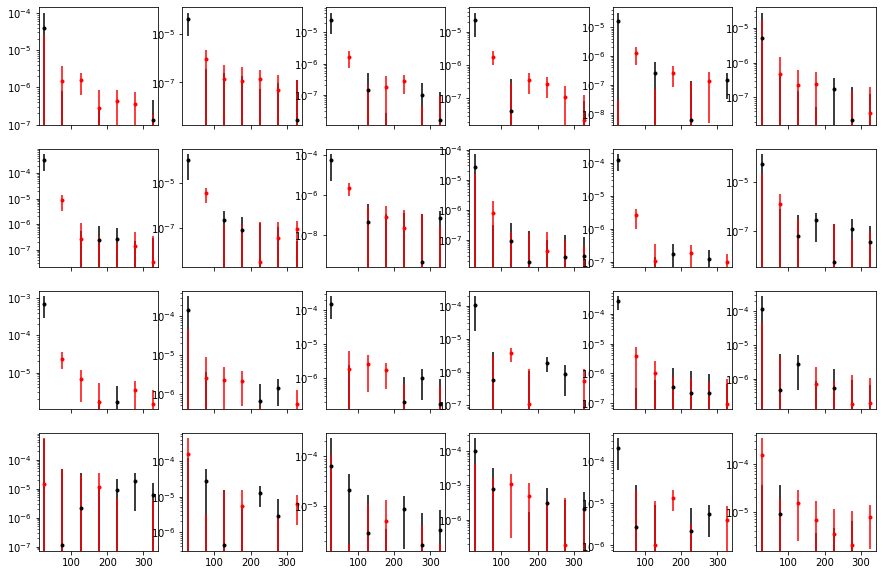

In [16]:
fig, axes = plt.subplots(n_nu, n_g,
                         figsize=(15, 10),
                         sharex=True,
                         sharey=False)
for i in range(n_nu):
    for j in range(n_g):
        ax = axes[i][j]
        ax.errorbar(ls, cls_all[i, j, :], yerr=cl_errors[i, j, :], fmt='k.')
        ax.errorbar(ls, -cls_all[i, j, :], yerr=cl_errors[i, j, :], fmt='r.')
        ax.set_yscale('log')

Save to file

In [17]:
np.savez("cls_nside{nside}_Y10.npz", ls=ls, cl=cls_all, cls_jk=cls_jk)